In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pystan
import arviz

from src.preprocess_data import (
    create_df,
)

from src.utils import print_results, get_class_probs, load_model, save_model

In [2]:
df = create_df("../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [8]:
model_dir = Path("../stan_models/")
model_name = "ordered_logistic_elo_diff_raw"

compile_model = True

In [37]:
if compile_model:
    model = pystan.StanModel(str(model_dir / f"{model_name}.stan"))
    save_model(model_dir / f"{model_name}.pkl", model)
else: 
    model = load_model(model_dir / f"{model_name}.pkl")
    print(f"Loaded model: {model_name}")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_246e0c2cb0d2386ce7c2d04f780a2bd0 NOW.


In [38]:
stan_data = {
    "num_games": len(train),
    "p1_elo_diff_p2": train["p1_elo_diff_p2_scaled"].values,
    "player_1_white": train["p1_white"].values.astype(int),
    "y": train["p1_outcome"].values,
    
    # Predict on test set:
    "num_test_games": len(test),
    "p1_elo_diff_p2_test": test["p1_elo_diff_p2_scaled"].values,
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [39]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [40]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [41]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,e,3.029,0.210,2.631,3.413,0.004,0.003,3167.0,3155.0,3168.0,2908.0,1.0
1,w,0.725,0.097,0.543,0.908,0.002,0.001,2593.0,2528.0,2599.0,2586.0,1.0
2,c[0],-0.906,0.076,-1.052,-0.766,0.002,0.001,2097.0,2097.0,2094.0,2313.0,1.0
3,c[1],1.694,0.083,1.536,1.845,0.001,0.001,3103.0,3076.0,3107.0,2893.0,1.0
4,ypred[0],1.077,0.286,1.000,2.000,0.005,0.003,3636.0,3621.0,3649.0,3666.0,1.0
5,ypred[1],2.655,0.543,2.000,3.000,0.009,0.006,4066.0,4053.0,4057.0,4000.0,1.0
6,ypred[2],2.803,0.440,2.000,3.000,0.007,0.005,4075.0,4075.0,4076.0,4000.0,1.0
7,ypred[3],1.248,0.480,1.000,2.000,0.008,0.005,4054.0,4054.0,4021.0,3901.0,1.0
8,ypred[4],1.444,0.581,1.000,2.000,0.009,0.007,3950.0,3950.0,3947.0,3871.0,1.0
9,ypred[5],2.713,0.509,2.000,3.000,0.008,0.006,4171.0,4170.0,4171.0,4000.0,1.0


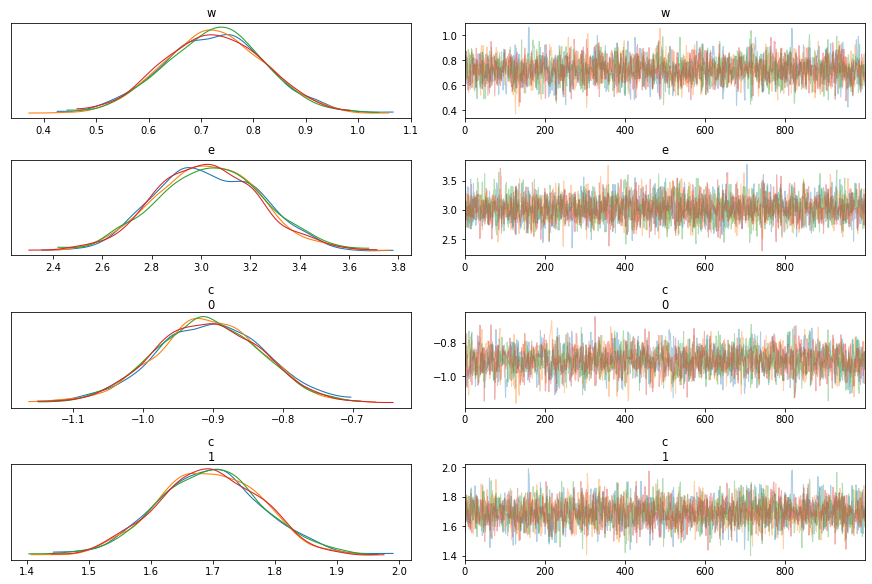

In [42]:
arviz.plot_trace(inference_data, var_names=["w", "e", "c"]);

In [43]:
train_cls_probs = get_class_probs(params, "ypred")
cls_pred = np.argmax(train_cls_probs, 1) + 1
print_results(train, cls_pred, "Train", dp=4)

Train - exact: 0.5507, out by one: 0.4440, out by two: 0.0053


In [44]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test", dp=4)

Test - exact: 0.5473, out by one: 0.4434, out by two: 0.0092


In [51]:
train.groupby("p1_outcome").size()

p1_outcome
1    419
2    868
3    400
dtype: int64

In [72]:
close_mask = np.abs(train["p1_elo_diff_p2"].values) < 50

train["close_game"] = close_mask

train.groupby(["p1_white", "close_game", "p1_outcome"]).size()

p1_white  close_game  p1_outcome
False     False       1             180
                      2             255
                      3             100
          True        1              87
                      2             158
                      3              58
True      False       1              97
                      2             285
                      3             173
          True        1              55
                      2             170
                      3              69
dtype: int64

In [74]:
train.groupby(["p1_white", "p1_outcome"]).size()

p1_white  p1_outcome
False     1             267
          2             413
          3             158
True      1             152
          2             455
          3             242
dtype: int64